This notebook performs comparisons between different vintages of the ESG dataset.

The reference dataset is the one used in the 2019 paper: https://github.com/worldbank/ESG_gaps_research

In [1]:
import pandas as pd
import numpy as np
import wbgapi as wb
import matplotlib.pyplot as plt

Define the path to latest database and the cutoff year for comparison. See `extract_esg_data2` in python/esg_loader.py for how to create the database.

In [2]:
latest_db = '../data/ESG_wbg-2021-10.csv'
cutoff_year = 2020

The repository includes database snapshots created at different points in time.
the ESG gaps paper uses ESG_wdi.feather, which is a database of 119 indicators
that includes both ones defined (at the time) in the Bank's ESG dataset as well
as those used in the broader ESG community found in other Bank databases.

There is also a ESG_wbg.feather database that ostensibly is a subset of ESG_wdi.feather
but apparently was built more recently and produces different results. Since
the point of this notebook is to show changes relative to the paper it loads the
ESG_wdi.feather file and then limits it to the indicators in the ESG dataset.

In [3]:
orig = pd.read_feather('../data/ESG_wdi.feather')
orig = orig[orig.indicatorID.isin(wb.series.Series(db=75).index)]

# original analysis stopped at 2018
orig = orig[(orig.date>=2000) & (orig.date<=2018)]

latest = pd.read_csv(latest_db)
latest = latest[(latest.date>=2000) & (latest.date<=cutoff_year)]

# sanity check that indicator lists are the same
(orig['indicatorID'].unique() == latest['indicatorID'].unique()).all()

True

In [4]:
orig2   = orig.groupby('indicatorID')['date'].max()
latest2 = latest.groupby('indicatorID')['date'].max()
orig_mry   = orig2.value_counts().sort_index()
latest_mry = latest2.value_counts().sort_index()

# show number of indicators by their mry
mry = pd.DataFrame({'original': orig_mry, 'latest': latest_mry})
mry

,original,latest
2009.0,2.0,2.0
2012.0,2.0,NaN
2014.0,2.0,NaN
2015.0,8.0,5.0
2016.0,8.0,3.0
2017.0,14.0,3.0
2018.0,27.0,9.0
2019.0,NaN,19.0
2020.0,NaN,22.0


In [5]:
# convert mry's to age, where current (0) is the year previous to the database (2018 for the original)

mry_rel = pd.DataFrame(columns=['original', 'latest'])
mry_rel.index.name = 'Age (years)'

for i in range(0,4):
    mry_rel.loc['current (previous year)' if i == 0 else str(i)] = [orig_mry.get(2018-i, 0), latest_mry.get(cutoff_year-i, 0)]

mry_rel.loc['4+']      = [orig_mry.sum() - mry_rel['original'].sum(), latest_mry.sum() - mry_rel['latest'].sum()]
mry_rel.loc['average'] = [2018 - np.mean(orig2), cutoff_year - np.mean(latest2)]

mry_rel

,original,latest
Age (years),,
current (previous year),27,22
1,14,19
2,8,9
3,8,3
4+,6,10
average,1.460317,1.666667


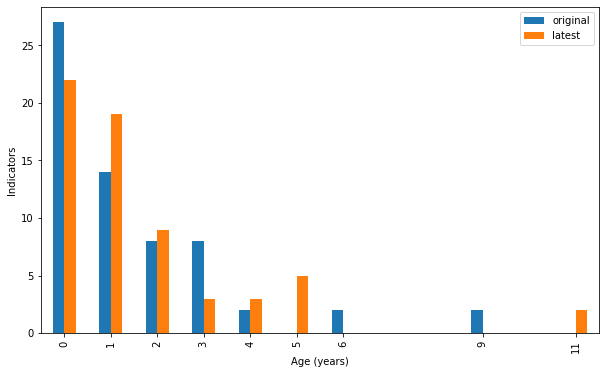

In [6]:
# Show age visually (although personally I prefer the summary table)
mry_rel2 = pd.DataFrame(columns=['original', 'latest'])

years = int(mry.index.max() - mry.index.min() +1)
for i in range(0, years):
    mry_rel2.loc[i] = [orig_mry.get(2018-i), latest_mry.get(cutoff_year-i)]

mry_rel2.dropna(how='all').plot(kind='bar',
    figsize=(10,6), xlabel='Age (years)', ylabel='Indicators')

plt.show()

In [7]:
# Drill down a bit; which "current" indicators in original are no longer current in latest?
status = orig[['indicatorID', 'indicator']].drop_duplicates().set_index('indicatorID')
status['age_orig'] = 2018 - orig2
status['age_latest'] = cutoff_year - latest2
status['change'] = status['age_latest'] - status['age_orig']

pd.options.display.max_rows = 75
status[(status.age_orig==0) & (status.age_latest>0)]

,indicator,age_orig,age_latest,change
indicatorID,,,,
EN.MAM.THRD.NO,"Mammal species, threatened",0.0,2,2.0
ER.PTD.TOTL.ZS,Terrestrial and marine protected areas (% of t...,0.0,2,2.0
IC.BUS.EASE.XQ,Ease of doing business index (1=most business-...,0.0,1,1.0
IC.LGL.CRED.XQ,Strength of legal rights index (0=weak to 12=s...,0.0,1,1.0
IP.PAT.RESD,"Patent applications, residents",0.0,1,1.0
SH.DYN.MORT,"Mortality rate, under-5 (per 1,000 live births)",0.0,1,1.0
SL.TLF.ACTI.ZS,"Labor force participation rate, total (% of to...",0.0,1,1.0
SL.TLF.CACT.FM.ZS,Ratio of female to male labor force participat...,0.0,1,1.0


In [8]:
# conversely, which indicators are now current that weren't before (an improvement)?
status[(status.age_orig>0) & (status.age_latest==0)]

,indicator,age_orig,age_latest,change
indicatorID,,,,
AG.LND.FRST.ZS,Forest area (% of land area),2.0,0,-2.0
SH.H2O.SMDW.ZS,People using safely managed drinking water ser...,1.0,0,-1.0
SH.STA.SMSS.ZS,People using safely managed sanitation service...,1.0,0,-1.0


In [9]:
# show the complete status table
# status.sort_values('change').to_clipboard()
status.sort_values('change')

,indicator,age_orig,age_latest,change
indicatorID,,,,
EN.ATM.NOXE.PC,Nitrous oxide emissions (metric tons of CO2 eq...,6.0,2,-4.0
EN.ATM.METH.PC,Methane emissions (metric tons of CO2 equivale...,6.0,2,-4.0
AG.LND.FRST.ZS,Forest area (% of land area),2.0,0,-2.0
EN.ATM.CO2E.PC,CO2 emissions (metric tons per capita),4.0,2,-2.0
SH.MED.BEDS.ZS,"Hospital beds (per 1,000 people)",3.0,1,-2.0
EG.ELC.RNEW.ZS,Renewable electricity output (% of total elect...,3.0,1,-2.0
SH.STA.SMSS.ZS,People using safely managed sanitation service...,1.0,0,-1.0
SH.DTH.COMM.ZS,"Cause of death, by communicable diseases and m...",2.0,1,-1.0
ER.H2O.FWTL.ZS,"Annual freshwater withdrawals, total (% of int...",4.0,3,-1.0
